In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Data Collection and Integration
- fully beneficial RLT treatment patients (**FBTP**)
- not fully beneficial RLT treatment patients (**NFBTP**)

## I. Original Data

In [2]:
# Load Data
file_name_1 = "../data/raw/ImagingParameter.xlsx"
roi = pd.read_excel(file_name_1, header=None)

file_name_2 = "../data/raw/MultiFactorAssessment.xlsx"
score = pd.read_excel(file_name_2, header=None)

file_name_3 = '../data/raw/PatientClinicalBiochemicalData.xlsx'
info = pd.read_excel(file_name_3, sheet_name= 0 ,header=[0, 1, 2])

### 1. ROI
Imaging parameters captured first and higher order statistical features (mean, minimum, max-imum, peak values, etc.) of regions of interest.

(Two tractors: PSMA and Choline)

In [3]:
# Divided to two columns
roi_PSMA = roi.iloc[:, :2]
roi_Choline = roi.iloc[:, 3:5]
roi_Choline = roi_Choline.rename(columns={3: 0, 4: 1})

# extract IDs and their ROW num
ID_rows = roi[roi.iloc[:, 0].apply(lambda x: isinstance(x, (int, float)))]
ID_row = pd.DataFrame({
    'ID': ID_rows.iloc[:, 0],
    'Row': ID_rows.index
})
ID_row = ID_row.dropna()
ID_row = ID_row.reset_index(drop  = True)


In [4]:
# function to extract 'ID', 'Date', 'Measure', 'PET', 'Value', 'Index' from tableau
def dataExtract(df, ID_row):
    data = []
    for i in range(len(ID_row)):
        start = ID_row.iloc[i]['Row']
        end = ID_row.iloc[i+1]['Row'] if i+1 < len(ID_row) else len(df)

        slice_df = df.iloc[start:end]
        ID = ID_row.iloc[i]['ID']

        # 提取日期
        date_row = slice_df.iloc[4]
        date = None

        measure = None
        pet = None

        for _, row in slice_df.iterrows():
            if isinstance(row[0], str):
                if len(row[0]) > 0:
                    measure = row[0]
                    index = 0
                    pet = str(row[1])
                    # _, pet = re.split('-', pet, maxsplit=1) # 用-隔开两部分，后面的是pet
                
            else:
                if measure and index < 7:
                    #type_ = slice_df.columns[1]
                    date = date_row[1]
                    raw_index = row[1]

                    if isinstance(raw_index, str):  # add this line
                        pattern = r'([\D]*)([\d.]+)(.*)'  # 定义匹配模式，([\D]*) 表示非数字部分，([\d.]+) 表示数字部分，包括浮点数
                        match = re.match(pattern, raw_index)
                        if match:
                            pre_index = match.group(1)  # 前缀部分
                            value = match.group(2)  # 数字部分
                            suf_index = match.group(3)  # 后缀部分
                            full_index = pre_index.strip() + ' ' + suf_index.strip()  # 把前缀和后缀合并，中间用空格隔开
                        data.append([ID, date, measure, pet, value, full_index])
                        index += 1

    return pd.DataFrame(data, columns=['ID', 'Date', 'Measure', 'PET', 'Value', 'Index'])


In [5]:
# extract all values from ROI.xlsx
Roi_Choline = dataExtract(roi_Choline, ID_row)
Roi_PSMA = dataExtract(roi_PSMA, ID_row)
Roi_Choline['Type'] = 'Choline'
Roi_PSMA['Type'] = 'PSMA'
Roi = pd.concat([Roi_PSMA, Roi_Choline]).reset_index(drop=True)

# transform it to .csv in the folder Data
Roi.to_csv('../data/processed/ImagineParameter.csv', index=False)

### 2. Score
- Scores from visually assessed bone invasion across ten skeletal segments were recorded
- Invasions of pelvic tissues, liver, and lungs were documented as binary yes/no variables
- Lymph node involvement was quantified numerically
- Textual records provided insights into the consistency and fixed states of the PSMA, Choline, and FDG tracers. 

In [6]:
# extract IDs and their ROW num
ID_rows = score[score.iloc[:, 0].apply(lambda x: isinstance(x, (int, float)))]
ID_row = pd.DataFrame({
    'ID': ID_rows.iloc[:, 0],
    'Row': ID_rows.index
})
ID_row = ID_row.dropna()
ID_row = ID_row.reset_index(drop  = True)

In [7]:
# ScoreBones in the table
def scoreBonesExtract(df, ID_row):
    
    data = []
    for i in range(len(ID_row)):
        start = ID_row.iloc[i]['Row']
        end = ID_row.iloc[i+1]['Row'] if i+1 < len(ID_row) else len(df)

        slice_df = df.iloc[start:end]
        ID = ID_row.iloc[i]['ID']

        row_counter = 0

        for _, row in slice_df.iterrows():
            if  not np.isnan(row[1]):
                value = row[1]
                index = row[0]

                data.append([ID, index, value])
                row_counter += 1

    return pd.DataFrame(data, columns=['ID', 'locBone_Inv', 'valBone_Inv'])

In [8]:
ScoreBones = score.iloc[:, :2]
ScoreBones.iloc[3]
ScoreBones.iloc[:, 1] = pd.to_numeric(ScoreBones.iloc[:, 1], errors='coerce')

ScoreBone = scoreBonesExtract(ScoreBones, ID_row)

In [9]:
# Numbers of Lymph node involvement - NumLN
invasion_NumLN = score.iloc[:,3 :6]
invasion_NumLN = invasion_NumLN.drop(invasion_NumLN.columns[1], axis=1)
invasion_NumLN.rename(columns={3: 0, 5: 1}, inplace=True)

In [10]:
# function to extract the value of NumLN and PTI from table
def tableExtract(df, ID_row, nbROW_valid):
    data = []
    for i in range(len(ID_row)):
        start = ID_row.iloc[i]['Row']
        end = ID_row.iloc[i+1]['Row'] if i+1 < len(ID_row) else len(df)

        slice_df = df.iloc[start:end]
        ID = ID_row.iloc[i]['ID']

        # counter
        row_counter = 0

        for _, row in slice_df.iterrows():
            if  isinstance(row[0], str):
                if len(row[0]) > 0:
                    if row_counter > 0 and row_counter < nbROW_valid + 1:
                        value = row[1]
                        index = row[0]

                        data.append([ID, index, value])
                row_counter += 1

    return pd.DataFrame(data)# , columns=['ID', 'locLN', 'numLN'])

In [11]:
NumLN = tableExtract(invasion_NumLN, ID_row, 2 )
NumLN.rename(columns={0:'ID', 1:'locLN_Inv', 2:'numLN_Inv'}, inplace=True)

In [12]:
# Pelvic Tissue Invasion - PTI
invasion_PTI = score.iloc[:, 8:10]
invasion_PTI.rename(columns={8: 0, 9: 1}, inplace=True)

def combine_columns(row):
    if row[2] == 'x':
        return 0 if row[1] == 'no' else 1
    return row[1]

PTI = tableExtract(invasion_PTI, ID_row, 2 )
PTI.iloc[:, 1] = PTI.apply(combine_columns, axis=1)
PTI[1] = pd.to_numeric(PTI[1], errors='coerce')
PTI = PTI.dropna().iloc[:, :2]
PTI.rename(columns={0:'ID', 1:'PTInv'}, inplace=True)
PTI.PTInv = PTI.PTInv.astype(bool)
#PTI.head(10)

In [13]:
# Lung and Liver Invasion - Lung, Liver

# extract the value from tables according the rows
# (begin from which row and how many rows are valid)
def rowExtract(df, ID_row, ROW):
    data = []
    for i in range(len(ID_row)):
        start = ID_row.iloc[i]['Row']
        end = ID_row.iloc[i+1]['Row'] if i+1 < len(ID_row) else len(df)

        slice_df = df.iloc[start:end]
        ID = ID_row.iloc[i]['ID']

        row_counter = 0

        for _, row in slice_df.iterrows():
            if  isinstance(row[0], str):
                if len(row[0]) > 0:
                    if row_counter == ROW - 1:
                        value = row[0]

                        data.append([ID, value])
                row_counter += 1
    return pd.DataFrame(data, columns=['ID', 'Value'])


# find the values in the table for lung and liver
Lung = rowExtract(invasion_NumLN, ID_row, 4 )
Lung.rename(columns={'Value':'Lung_Inv'}, inplace=True)
Liver = rowExtract(invasion_PTI, ID_row, 4 )
Liver.rename(columns={'Value':'Liver_Inv'}, inplace=True)

In [14]:
# Textual records - Analyse

# extract the analytical text from Score table
def analyseExtract(df, ID_row):
    data = []
    for i in range(len(ID_row)):
        start = ID_row.iloc[i]['Row']
        end = ID_row.iloc[i+1]['Row'] if i+1 < len(ID_row) else len(df)

        slice_df = df.iloc[start:end]
        ID = ID_row.iloc[i]['ID']

        row_counter = 0

        for _, row in slice_df.iterrows():
            if  isinstance(row[0], str):
                if len(row[0]) > 0:
                    if row_counter >3:
                        value = row[0]

                        data.append([ID, value])
                row_counter += 1
    return pd.DataFrame(data, columns=['ID', 'Analysis'])

Analysis = analyseExtract(invasion_NumLN, ID_row )

In [15]:
# Score data merging - Score

Score = ScoreBone.merge(NumLN, on='ID', how='outer')
Score = Score.merge(PTI, on='ID', how='outer')
Score = Score.merge(Lung, on='ID', how='outer')
Score = Score.merge(Liver, on='ID', how='outer')
Score = Score.merge(Analysis, on='ID', how='outer')

Score.to_csv('../data/processed/MultiFactorAssessment.csv', index=False)

### 3. InfoPatient - Info
Biological parameters included 
- Clinical Parameters
    - Age
    - TNM Classification
    - WHO Performance Status
    - Measurement Date (divided into Pre-cure Date and Post-cure Date)
- Biochemical Evaluations 
    - Hematology (Complete Blood Counts): Hemoglobin, Leukocytes, Neutrophils, Lymphocytes, Platelets
    - Liver Function Tests: ASAT (Aspartate Aminotransferase), ALAT (Alanine Aminotransferase), Total Bilirubin, Albumin, ALP (Alkaline Phosphatase)
    - Kidney Function Tests: GFR (Glomerular Filtration Rate), Creatinine
    - PSA levels (Prostate-Specific Antigen)

In [16]:
# delete all blank row and colons & flatten the multi-level index
Info = info.dropna(axis=1, how='all')
Info = Info.dropna(axis=0, how='all')

new_columns = []

for col in Info.columns:
    col_parts = []

    for part in col:
        part = part.strip()
        if not part.startswith('Unnamed'):
            col_parts.append(part)

    new_name = '_'.join(col_parts).replace(' ', '_')
    new_name = re.sub(r'_+', '_', new_name)
    new_name = re.sub(r'_\(', '(', new_name)

    new_columns.append(new_name)

Info.columns = new_columns

Info = Info[~((Info.iloc[:, 0].apply(lambda x: isinstance(x, str))) & (Info.iloc[:, 1].isnull()))]

Info.rename(columns={Info.columns[0]: 'ID'}, inplace=True)

In [17]:
# Separate TNM and Gleason
# Original TNM col has two parts: real TNM and Gleason
Info = Info.rename(columns={"TNM": "Gleason"})
Info.insert(Info.columns.get_loc("Gleason") + 1, "TNM", np.nan)

mask = Info['Gleason'].str.contains("T|N|R", na=False)
Info.loc[mask, 'TNM'] = Info.loc[mask, 'Gleason']
Info['TNM'] = Info['TNM'].shift(-1)
Info.loc[mask, 'Gleason'] = np.nan
Info = Info.dropna(axis=0, how='all')

C:\Users\86187\AppData\Local\Temp\ipykernel_28532\440987334.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['pT3a pN0 Rx' 'T3 Nx M1' 'pTx pNx Rx' 'pT2b N0 M0 R1' 'pT3b' 'T3b N+']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Info.loc[mask, 'TNM'] = Info.loc[mask, 'Gleason']


In [18]:
# Format
col_counts = {}
new_columns = []
for col in Info.columns:
    if col in col_counts:
        col_counts[col] += 1
        new_columns.append(f"{col}_{col_counts[col]}")
    else:
        col_counts[col] = 0
        new_columns.append(col)
Info.columns = new_columns

Info.rename(columns={Info.columns[-1]: 'SalivaryGland_Value', Info.columns[-2]: 'SalivaryGland_Index'}, inplace=True)
Info.drop(Info.columns[-4], axis=1, inplace=True)


In [19]:
# transform it to .csv in the folder Data
Info.to_csv('../data/processed/PatientClinicalBiochemicalData.csv', index=False)

### 4. Classification of patients - Class
- Classsification of 25 patients - FBTP/NFBTP
- Status of the patients - IN PROGRESS / STOPPED / END OF TREATMENT / DECEASED
- Tractor used - PSMA / FDG / Choline

In [20]:
# get rows numbers of status
def getIdInfo(df):
    status_rows = df[(df.iloc[:, 0].apply(lambda x: isinstance(x, str))) & (df.iloc[:, 1].isnull())]
    
    status_rows = pd.DataFrame({
        'Status': status_rows.iloc[:, 0],
        'Row': status_rows.index
    })
    status_rows = status_rows.dropna()
    status_rows = status_rows.reset_index(drop=True)
    
    return status_rows

# get IDs appeared between the corresponding row numbers
def getIds(start: int, end: int, df: pd.DataFrame) -> pd.DataFrame:

    #if start < 0 or end > len(df) or start > end:
        #raise ValueError("Invalid row numbers.")

    subset = df.iloc[start:end]

    unique_ids = subset.iloc[:, 0].unique()

    unique_ids = [uid for uid in unique_ids if str(uid).isdigit()]

    unique_ids_df = pd.DataFrame(unique_ids, columns=['ID'])

    return unique_ids_df

In [21]:
# Classification

ID_ROI =  getIdInfo(roi)
# ID_R - Repondeurs
ID_FBTP = getIds(0, 614, roi)

# ID_P - Non  repondurs
ID_NFBTP = getIds(614, 1430, roi)

# combine all response data
ID_FBTP['FBTP/NFBTP'] = 'FBTP'
ID_NFBTP['FBTP/NFBTP'] = 'NFBTP'

idsInfo_PR = pd.concat([ID_FBTP, ID_NFBTP])
idsInfo_PR.reset_index(drop=True, inplace=True)
idsInfo_PR['ID'] = idsInfo_PR['ID'].astype(int)
idsInfo_PR.sort_values('ID', inplace=True)
# idsInfo.set_index('ID', inplace=True)
idsInfo_PR.reset_index(drop=True, inplace=True)

In [22]:
# Status

ID_infoPatient = getIdInfo(info)
# ID_EC - IN PROGRESS
ID_EC1 = getIds(0, 22, info)
ID_EC2 = getIds(69, 72, info)
ID_EC = pd.concat([ID_EC1, ID_EC2], ignore_index=True)

# ID_AR - STOPPED
ID_AR1 = getIds(22, 41, info)
ID_AR2 = getIds(72, 78, info)
ID_AR = pd.concat([ID_AR1, ID_AR2], ignore_index=True)

# ID_FDC - END OF TREATMENT
ID_FDC1 = getIds(41, 56, info)
ID_FDC2 = getIds(78, 100, info)
ID_FDC = pd.concat([ID_FDC1, ID_FDC2], ignore_index=True)

# ID_DEC - DECEASED
ID_DEC = getIds(56, 69, info)

# Combine status data
ID_EC['Status'] = 'IN PROGRESS'
ID_AR['Status'] = 'STOPPED'
ID_FDC['Status'] = 'END OF TREATMENT'
ID_DEC['Status'] = 'DECEASED'

idsInfo_St = pd.concat([ID_EC, ID_AR, ID_FDC, ID_DEC])
idsInfo_St.reset_index(drop=True, inplace=True)
idsInfo_St['ID'] = idsInfo_St['ID'].astype(int)
idsInfo_St.sort_values('ID', inplace=True)
# idsInfo.set_index('ID', inplace=True)
idsInfo_St.reset_index(drop=True, inplace=True)

In [23]:
# Tractor
# PSMA
ID_PSMA = getIds(0, 2400, roi)
#  FDG
ID_FDG = pd.DataFrame()
ID_FDG['ID'] = [30, 1, 8, 10, 15, 19, 28, 33, 36]
# Choline
ID_Choline = getIds(0, 1808, roi)

# Combine tractor data
ID_PSMA['Tractor'] = 'PSMA'
ID_FDG['Tractor'] = 'FDG'
ID_Choline['Tractor'] = 'Choline'

idsInfo_Tra = pd.concat([ID_PSMA, ID_FDG, ID_Choline])
idsInfo_Tra.reset_index(drop=True, inplace=True)
idsInfo_Tra['ID'] = idsInfo_Tra['ID'].astype(int)

idsInfo_Tra = idsInfo_Tra.groupby('ID')['Tractor'].apply(', '.join).reset_index()
idsInfo_Tra.sort_values('ID', inplace=True)
idsInfo_Tra.reset_index(drop=True, inplace=True)

In [24]:
# Summary
Class = pd.merge(idsInfo_PR, idsInfo_St, on='ID', how='outer')
Class = pd.merge(Class, idsInfo_Tra, on='ID', how='outer')

In [25]:
Class

,ID,FBTP/NFBTP,Status,Tractor
0,1,NFBTP,END OF TREATMENT,"PSMA, FDG, Choline"
1,2,FBTP,STOPPED,"PSMA, Choline"
2,3,NFBTP,IN PROGRESS,"PSMA, Choline"
3,4,NFBTP,END OF TREATMENT,"PSMA, Choline"
4,5,FBTP,STOPPED,"PSMA, Choline"
5,6,FBTP,STOPPED,"PSMA, Choline"
6,7,NFBTP,IN PROGRESS,"PSMA, Choline"
7,8,NFBTP,IN PROGRESS,"PSMA, FDG, Choline"
8,10,NFBTP,IN PROGRESS,"PSMA, FDG, Choline"
9,11,NFBTP,END OF TREATMENT,"PSMA, Choline"


## II. Data Merging 
The data were meticulously extracted, organized, and integrated from frontline medical records to form an initial dataset,complete with detailed data documentation.

In [647]:
# Original Patiens Data - OrigData
Roi_Merging = Roi.copy()
Score_Merging = Score.copy()
Info_Merging = Info.copy()
Class_Merging = Class.copy()

Roi_Merging["Roi_index"] = Roi_Merging.groupby("ID").cumcount()
Score_Merging["Score_index"] = Score_Merging.groupby("ID").cumcount()
Class_Merging["Class_index"] = Class_Merging.groupby("ID").cumcount()

Roi_Merging.set_index(["ID", "Roi_index"], inplace=True)
Score_Merging.set_index(["ID", "Score_index"], inplace=True)
Class_Merging.set_index(["ID", "Class_index"], inplace=True)

max_len = max(Roi_Merging.reset_index()["Roi_index"].max(), Score_Merging.reset_index()["Score_index"].max(), Class_Merging.reset_index()["Class_index"].max())
Info_Merging = pd.concat([Info_Merging] * (max_len + 1))

Info_Merging["Info_index"] = Info_Merging.groupby("ID").cumcount()
Info_Merging.set_index(["ID", "Info_index"], inplace=True)

OrigData = pd.concat([Roi_Merging, Score_Merging, Info_Merging, Class_Merging], axis=1)
OrigData.to_csv('../data/processed/OriginalPatientData.csv', index=True)

# Data Cleaning
- Standardized the data representation based on expert consensus
- Unified variables and address data sparsity issues. Binaried variables were converted to Boolean or 0/1 format


- For textual data, useful information was collected and a predefined encoding scheme was used.

### 1. Presentation Standardization

In [648]:
# For Roi data
# modify data type
Roi['Value'] = Roi['Value'].astype(float)

# 2D data
roiValue = Roi.pivot_table(index=['ID', 'Measure', 'Type'], columns='Index', values='Value')
roiValue = roiValue.reset_index()
# Small problem, unified unit - cm3->mm3
roiValue.loc[roiValue['Vol.: cm3'].notna(), 'Vol.: cm3'] *= 1000
roiValue['Vol.: mm3'] = roiValue['Vol.: mm3'].fillna(roiValue['Vol.: cm3'])
roiValue.drop(columns=['Vol.: cm3'], inplace=True)
# roiValue.iloc[9:20]

In [649]:
# For Score data
# OS Scores
scoreOsValue = Score.pivot_table(index='ID', columns='locBone_Inv', values='valBone_Inv', aggfunc='mean')
scoreOsValue = scoreOsValue.reset_index()

scoreOsValue.columns = [col if col == 'ID' else col + '_Inv' for col in scoreOsValue.columns]

# scoreOsValue

# numLN
numLNValue = pd.DataFrame()
sus_data = Score[Score['locLN_Inv'] == 'supradiaphragmatic']
sous_data = Score[Score['locLN_Inv'] == 'subdiaphragmatic']
sus_data = sus_data.drop_duplicates(subset=['ID', 'locLN_Inv'], keep='first')
sous_data = sous_data.drop_duplicates(subset=['ID', 'locLN_Inv'], keep='first')
numLNValue['SupraNumLN_Inv'] = sus_data.set_index('ID')['numLN_Inv']
numLNValue['SubNumLN_Inv'] = sous_data.set_index('ID')['numLN_Inv']
numLNValue.sort_index(axis=0, inplace=True)
numLNValue = numLNValue.reset_index()

# PTI
ptiValue = Score.drop_duplicates(subset=['ID', 'PTInv'], keep='first')
ptiValue = ptiValue[['ID', 'PTInv']].dropna()

new_data = {'ID': [36], 'PTInv': [False]}
ptiValue = pd.concat([ptiValue, pd.DataFrame(new_data)], ignore_index=True)

ptiValue = ptiValue.sort_values(by='ID')
ptiValue.reset_index(drop=True, inplace=True)

# Lung, Liver transform to text
def convert_value(val):
    if isinstance(val, str):
        if "0" in val:
            return 0
        else:
            return 1
    else:
        return np.nan

Score[['Lung_Inv', 'Liver_Inv']] = Score[['Lung_Inv', 'Liver_Inv']].applymap(convert_value)

Score['PLung_Inv_txt'] = Score['Lung_Inv'].apply(lambda x: x if isinstance(x, str) else np.nan)
Score['Liver_Inv_txt'] = Score['Liver_Inv'].apply(lambda x: x if isinstance(x, str) else np.nan)

poufoiValue = Score.drop_duplicates(subset=['ID', 'Lung_Inv', 'Liver_Inv'], keep='first')
poufoiValue = poufoiValue[['ID', 'Lung_Inv', 'Liver_Inv']]
poufoiValue.reset_index(drop=True, inplace=True)

scoreValue = pd.concat([scoreOsValue, numLNValue, ptiValue, poufoiValue], axis=1)

C:\Users\86187\AppData\Local\Temp\ipykernel_4536\2996610316.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Score[['Lung_Inv', 'Liver_Inv']] = Score[['Lung_Inv', 'Liver_Inv']].applymap(convert_value)


In [651]:
# Info data
# Gleason
Info['Gleason'] = Info['Gleason'].replace('x', np.nan)
Info['Gleason'] = Info['Gleason'].str.extract('(\d+)').astype(float)

# all x -> Nan
def convert_column(df, col):
    def convert_value(val):
        if isinstance(val, (int, float)):
            return float(val)
        if not isinstance(val, str):  
            match = re.search(r"(\d+)", val)
            if match:
                return float(match.group(1))
        return np.nan

    df[col] = df[col].apply(convert_value)
    return df

Info = convert_column(Info, 'Pre-cure_Kidney_GFR(mL/min)')

start_col = 8
end_col = -2

column_names = Info.columns

for col in column_names[start_col:end_col]:
    Info = convert_column(Info, col)

# only SalivaryGland_Value
Info = Info.drop(columns='SalivaryGland_Index')
Info['SalivaryGland_Value'] = Info['SalivaryGland_Value'].apply(lambda x: None if x == 'x' else bool(x))

# infoValue = Info.drop("TNM", axis=1)
infoValue = Info
infoValue = infoValue.sort_values(by='ID')
infoValue.reset_index(drop=True, inplace=True)

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\86187\AppData\Local\Temp\ipykernel_4536\3584798555.py:4: SyntaxWarning: invalid escape sequence '\d'
  Info['Gleason'] = Info['Gleason'].str.extract('(\d+)').astype(float)


In [652]:
# Standardize variable types and representations
# 'FBTP/NFBTP'
Class['FBTP/NFBTP'] = Class['FBTP/NFBTP'].replace({'NFBTP': 0, 'FBTP': 1})
# PTInv
scoreValue['PTInv'] = scoreValue['PTInv'].astype(np.int64)

# NumLN_Inv
scoreValue['SupraNumLN_Inv'] = scoreValue['SupraNumLN_Inv'].astype(np.int64)
scoreValue['SubNumLN_Inv'] = scoreValue['SubNumLN_Inv'].astype(np.int64)

# Gleason - 0 for missing vale
infoValue['Gleason'].fillna(0, inplace=True)
infoValue['Gleason'] = infoValue['Gleason'].astype(np.int64)
# WHO
infoValue['WHO'] = infoValue['WHO'].astype(np.int64)


C:\Users\86187\AppData\Local\Temp\ipykernel_4536\1813651795.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Class['FBTP/NFBTP'] = Class['FBTP/NFBTP'].replace({'NFBTP': 0, 'FBTP': 1})
C:\Users\86187\AppData\Local\Temp\ipykernel_4536\1813651795.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  

### 2. Variable unification based on expert knowledge

In [653]:
# For Roi data
# definition mapping
mapping = {
    'Liver': ['Liver'],
    'LymphNode+': ['Lymph Node + fixing (supradiaphragmatic)', 'Lymph Node + fixing (subdiaphragmatic)', 'Lymph Node + fixing (mediastinal)', 'Lymph Node (supradiaphragmatic)', ],
    'LymphNode-': ['Lymph Node - fixing (supradiaphragmatic)', 'Lymph Node - fixing (subdiaphragmatic)', 'Lymph Node - fixing', 'Lymph Node (supradiaphragmatic)', ],
    'Lung/PulmonaryNodule+': ['Pulmonary nodule + fixing', 'Lung', 'Lung + fixing'],
    'Lung/PulmonaryNodule-': ['Pulmonary nodule - fixing', 'Lung', 'Lung - fixing'],
    'Bone+': ['Bone + fixing (Pelvis R)', 'Bone + fixing (Rib L)', 'Bone + fixing (femur L)', 'Bone + fixing (Thoracic Spine)', 'Bone + fixing (Lumbar Spine)', 
              'Bone + fixing (Scapula)', 'Bone + fixing (femur R)', 'Bone + fixing (Pelvis L)', 'Bone + fixing (Humerus L)', 'Bone + fixing (Rib R)', 'Bone (Thoracic Spine)', 
              'Bone + fixing (Hip R)', 'Bone + fixing (sternum)', 'Bone + fixing (Hip L)'],
    'Bone-': ['Bone - fixing (Pelvis L)', 'Bone - fixing (Scapula L)', 'Bone - fixing (Humerus R)', 'Bone - fixing (Scapula R)', 'Bone - fixing (Humerus L)', 
              'Bone - fixing (Clavicle L)', 'Bone - fixing (Thoracic Spine)', 'Bone - fixing (Rib L)', 'Bone - fixing (Rib R)', 'Bone - fixing (Pelvis R)', 'Bone - fixing (femur L)',
              'Bone - fixing (coccys)', 'Bone (Thoracic Spine)', 'Bone - fixing (femur R)', 'Bone - fixing (Lumbar Spine)', 'Bone - fixing (Hip R)', 'Bone - fixing (sternum)', 'Bone - fixing (Hip L)'],
    'Kidney': ['Kidney'],
    'Prostate': ['Prostate', 'Pelvic mass in the prostatic region + fixing'],
    'SalivaryGland': ['Salivary Gland'],
    'Thyroïde': ['Thyroïde']
}

reverse_mapping = {measure: category for category, measures in mapping.items() for measure in measures}

# application mapping
def map_category(x):
    return reverse_mapping.get(x, 'Other')
roiValue['Measure'] = roiValue['Measure'].apply(map_category)

roiValue = pd.pivot_table(
    roiValue, 
    values=['Max: g/ml*', 'Min: g/ml*', 'Mean: g/ml*', 'Peak: g/ml*', 'ROI (thr%=42)', 'Vol.: mm3', 'Std. dev: g/ml*'], 
    index=['ID'], 
    columns=['Type', 'Measure'], 
    aggfunc='mean'
)

roiValue.columns = ['_'.join(col).strip().replace('*', '') for col in roiValue.columns.values]
roiValue = roiValue.reset_index()
# roiValue

### 3. Textual Data Collection and Numericalization

#### Standard
**Fixation**

- Fixation_PSMA: -1: No PSMA / 0: No fixation zone / 1: Fixation / 2: Hyperfixation
- Fixation_choline: -1: No choline / 0: No fixation zone / 1: Fixation / 2: Hyperfixation
- Fixation_FDG: -1: No FDG / 0: No fixation zone / 1: Fixation / 2: Hyperfixation

**Discordance**
- Discordance: -1: No fixation zone / 0: No discordance among PSMA, choline, and FDG / 1: Presence of discordance
(General Discordance, Comparison of PSMA and choline if FDG is absent)

- PSMA-Choline Discordance: -1: No fixation zone / 0: No discordance between PSMA and choline (Concordance) / 1: Presence of discordance between PSMA and choline

- PSMA-FDG Discordance: -1: Data missing / 0: No discordance between PSMA and FDG (Concordance) / 1: Presence of discordance between PSMA and FDG

- Choline-FDG Discordance: -1: Data missing / 0: No discordance between choline and FDG (Concordance) / 1: Presence of discordance between choline and FDG


**Difference**

- Difference_PSMA-choline: -1: Data missing / 0: No difference (totally same, rarely) / 1: PSMA-, choline+ / 2: PSMA+, choline-

- Difference_PSMA-FDG: -1: Data missing / 0: No difference (totally same, rarely) / 1: PSMA-, FDG+ (existence of FDG+) / 2: PSMA+, FDG-

- Difference_choline-FDG: -1: Data missing (don't know) / 0: No difference (totally same, rarely) / 1: choline-, FDG+ / 2: choline+, FDG-

In [654]:
columns = ['ID',
'Fixation_PSMA', 'Fixation_choline', 'Fixation_FDG',
'Discordance', 'Discordance_PSMA-choline', 'Discordance_PSMA-FDG', 'Discordance_choline-FDG',
'Difference_PSMA-choline', 'Difference_PSMA-FDG', 'Difference_choline-FDG']

dataText = pd.DataFrame(columns=columns, dtype=int)
# repondeurs
dataText.loc[0] = [2,   0,0,-1, -1,-1,-1,-1,0,-1,-1]
dataText.loc[1] = [5,   1,1,-1, 1,1,-1,-1,  1,-1,-1]
dataText.loc[2] = [6,   1,1,-1, 1,1,-1,-1,  2,-1,-1]
dataText.loc[3] = [16,  1,1,1,  1,1,1,1,    2,2,-1]
dataText.loc[4] = [20,  0,0,-1, -1,-1,-1,-1,0,-1,-1]
dataText.loc[5] = [21,  2,1,-1, 1,1,-1,-1,  2,-1,-1]
dataText.loc[6] = [22,  1,1,1,  1,0,1,1,    0,2,2]
dataText.loc[7] = [23,  2,2,-1, 0,0,-1,-1,  0,-1,-1]
dataText.loc[8] = [30,  2,2,2,  1,0,1,1,    0,2,2]
dataText.loc[9] = [31,  2,2,2,  0,0,0,0,    0,0,0]
dataText.loc[10]= [32,  2,2,2,  0,0,0,0,    0,0,0]

# non-repondeurs
dataText.loc[11]= [1,   2,1,1,  1,1,1,1,    2,1,0]
dataText.loc[12]= [3,   1,1,-1, 0,0,-1,-1,  1,-1,-1]
dataText.loc[13]= [4,   1,1,-1, 1,1,-1,-1,  1,-1,-1]
dataText.loc[14]= [7,   0,0,-1, -1,-1,-1,-1,0,-1,-1]
dataText.loc[15]= [8,   1,1,1,  1,1,1,1,    1,1,1]
dataText.loc[16]= [10,  2,2,1,  1,1,1,1,    1,1,2]
dataText.loc[17]= [11,  1,1,-1, 1,1,-1,-1,  1,-1,-1]
dataText.loc[18]= [12,  0,0,-1, -1,-1,-1,-1,0,-1,-1]
dataText.loc[19]= [15,  1,1,1,  1,1,0,1,    1,2,2]
dataText.loc[20]= [19,  2,1,1,  1,1,1,1,    2,1,-1]
dataText.loc[21]= [24,  1,1,-1, 0,0,-1,-1,  0,-1,-1]
dataText.loc[22]= [28,  2,2,2,  1,1,1,1,    2,1,-1]
dataText.loc[23]= [33,  2,1,1,  1,1,1,1,    2,1,-1]
dataText.loc[24]= [36,  2,1,2,  1,1,1,1,    1,2,2]

# sorted
dataText = dataText.sort_values(by='ID')
dataText.reset_index(drop=True, inplace=True)

In [655]:
dataValue = pd.concat([infoValue, scoreValue, roiValue], axis=1)
dataValue = dataValue.join(Class['FBTP/NFBTP'])

CleanedData = pd.concat([dataValue, dataText], axis=1)
# Delete the dupicated ID columns
CleanedData = CleanedData.loc[:, ~CleanedData.columns.duplicated(keep='first')]


CleanedData.to_csv('../data/processed/CleanedData.csv', index=False)

# Feature Engineering

- Data Analysis and Visualization:
    - Understand Data Structure and Characteristics: Analyze the data to gain insights into its overall structure and inherent characteristics.
    - Variable Categorization: Classify variables as either continuous or categorical to ensure compatibility with different algorithms.
- Data Pruning:  -> **Data_con, Data_cat**
    - Explore new variables
    - Eliminate Irrelevant Data: Remove data elements that do not contribute to the prediction target, such as patient condition classification.
    - Address Sparse Data: Discard overly sparse data resulting from excessive missing values to enhance model reliability and performance.
- Data Normalization and Encoding: -> **Data**
    - Normalize Continuous Variables: Apply normalization techniques, such as Z-score normalization, to scale continuous variables, aiding in uniform data interpretation by machine learning models.
    - Encode Categorical Variables: Utilize appropriate encoding methods(one-hot encoding adn ordinal encoding) to transform categorical variables into a format suitable for machine learning algorithms.

### 1. Data Analysis

In [656]:
Data = CleanedData.copy()

In [657]:
# CleanedData -> 201 columns
# Display basic information about the data
print("Basic Information about the Data:")
Data.info()

# Display descriptive statistics
print("\nDescriptive Statistics:")
print(Data.describe())

# Check for missing values
print("\nMissing Values Status:")
print(Data.isnull().sum())

# Overview of data types
print("\nData Types:")
print(Data.dtypes)

Basic Information about the Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Columns: 201 entries, ID to Difference_choline-FDG
dtypes: datetime64[ns](1), float64(179), int64(18), object(3)
memory usage: 39.4+ KB

Descriptive Statistics:
             AGE    Gleason        WHO        Pre-cure_Date  \
count  25.000000  25.000000  25.000000                   25   
mean   72.120000   6.920000   0.960000  2022-07-05 18:14:24   
min    50.000000   0.000000   0.000000  2021-12-20 00:00:00   
25%    64.000000   7.000000   1.000000  2022-04-09 00:00:00   
50%    74.000000   8.000000   1.000000  2022-07-26 00:00:00   
75%    78.000000   8.000000   1.000000  2022-08-30 00:00:00   
max    85.000000  10.000000   2.000000  2023-01-23 00:00:00   
std     8.569909   2.767671   0.538516                  NaN   

       Pre-cure_Kidney_GFR(mL/min)  Pre-cure_Kidney_Creatinine(µmol/L)  \
count                    21.000000                           25.000000   
mean               

### 2. Data Pruning

In [658]:
# TNM for different stage, so we divided it to 3 variables
def extract_T_stage(TNM):
    t_stage = re.search('T([0-9]+[a-c]?)', TNM)
    return t_stage.group(1) if t_stage else 'unknown'

def extract_N_stage(TNM):
    n_stage = re.search('N([0-9]+[a-c]?)', TNM)
    return n_stage.group(1) if n_stage else 'unknown'

def extract_M_stage(TNM):
    m_stage = re.search('M([0-9]+[a-c]?)', TNM)
    return m_stage.group(1) if m_stage else 'unknown'

# TNM missing value
Data['TNM'].fillna("unknown", inplace=True)

# extract T_stage, N_stage, M_stage from TNM
Data['T_stage'] = Data['TNM'].apply(lambda x: extract_T_stage(x))
Data['N_stage'] = Data['TNM'].apply(lambda x: extract_N_stage(x))
Data['M_stage'] = Data['TNM'].apply(lambda x: extract_M_stage(x))


C:\Users\86187\AppData\Local\Temp\ipykernel_4536\1040775711.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Data['TNM'].fillna("unknown", inplace=True)


In [659]:
# Delete unnecessary data
# 'TNM'
Data.drop('TNM', axis=1, inplace=True)
# GS
Data.drop('SalivaryGland_Value', axis=1, inplace=True)
# Post-treatment biochemical data 
# cannot be used as predictive data
Data = Data[Data.columns.drop(list(Data.filter(regex='Post')))]
# Date 
Data.drop('Pre-cure_Date', axis=1, inplace=True)
# Data.drop('Post-cure_Date', axis=1, inplace=True)

# ROI and Volume are not important, be deleted
columns_to_drop = [col for col in Data.columns if 'ROI' in col or 'Vol' in col]
Data = Data.drop(columns=columns_to_drop)

In [660]:
# Different stages of TNM missing values are set to 'unknow'
Data.replace('unknown', pd.NA, inplace=True)
# The number and proportion of missing values
missing_values = Data.isnull().sum()
missing_percentage = missing_values / len(Data) * 100
missing_df = pd.DataFrame({'missing_values': missing_values, 'percentage': missing_percentage})
missing_df = missing_df.sort_values(by='percentage', ascending=False)
# print(missing_df.head(40))

# Delete columns with a missing ratio greater than 80%
cols_to_drop = missing_df[missing_df['percentage'] > 80].index
Data = Data.drop(columns=cols_to_drop)

# missing value
Data.loc[:, Data.select_dtypes(include=['float64']).columns] = Data.select_dtypes(include=['float64']).fillna(0)


In [661]:
Data.set_index('ID', inplace=True)
Data_var = Data.copy()
Data_lab = Data_var.pop('FBTP/NFBTP')
Data_con = Data_var.select_dtypes(include=['float64'])
Data_cat = Data_var.select_dtypes(include=['int64','object'])


In [662]:
Data_con.to_csv('../data/processed/Data_continuous.csv')
Data_cat.to_csv('../data/processed/Data_categorical.csv')
Data_lab.to_csv('../data/processed/Data_label.csv')

### 3. Visualization

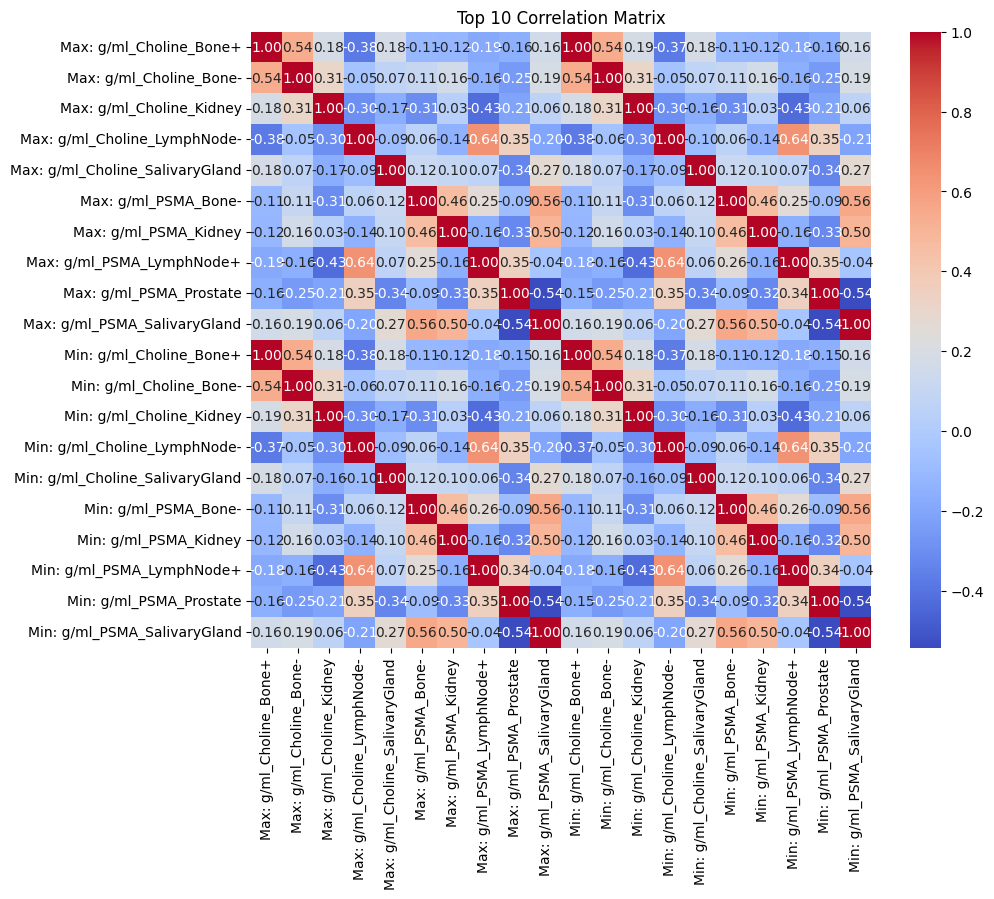

In [663]:
# correlation heatmap (top 10)
corr = Data_con.corr()

corr_triu = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))
top_corr = corr_triu.stack().nlargest(10)

top_corr_df = Data_con[top_corr.index.get_level_values(0).union(top_corr.index.get_level_values(1))].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 10 Correlation Matrix')
plt.show()

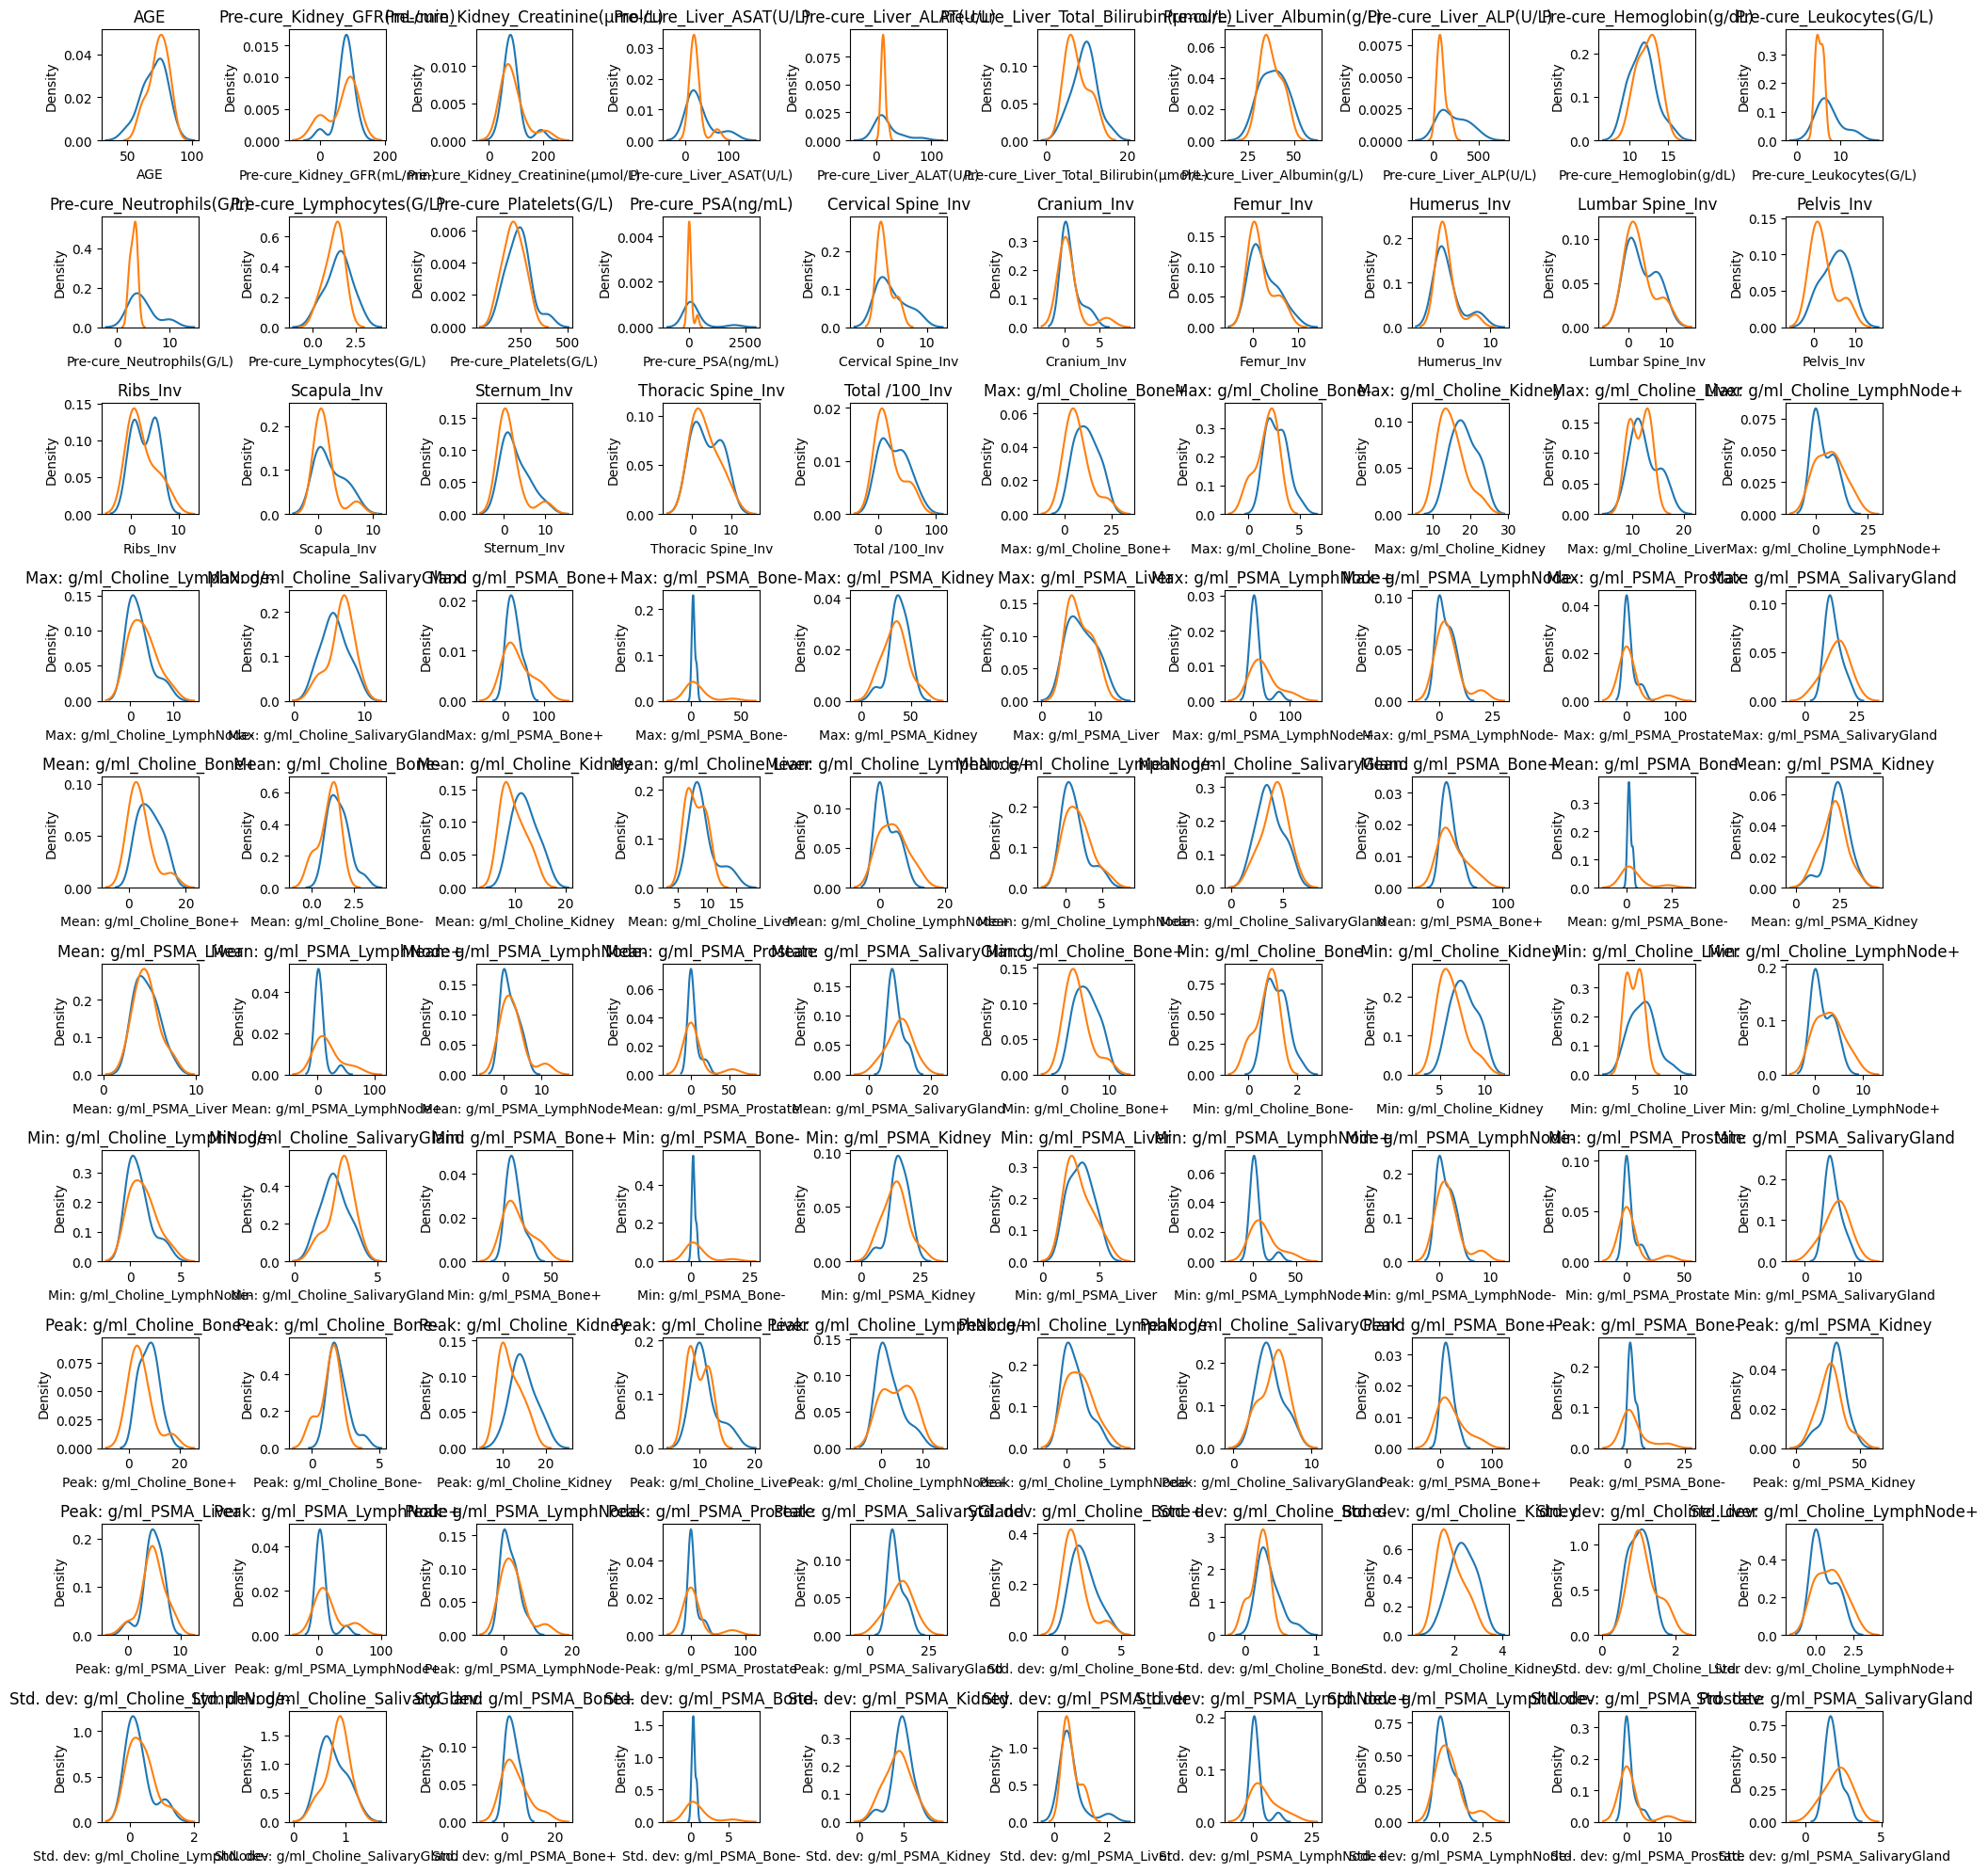

In [664]:
# Distribution of all continuous variables
df = pd.concat([Data_con, Data_lab], axis=1)

n_cols = 10
n_rows = int(np.ceil(len(Data_con.columns) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

for idx, col in enumerate(Data_con.columns):
    ax = axs[idx // n_cols, idx % n_cols]
    
    for y_val in Data_lab.unique():
        sns.kdeplot(df[df[Data_lab.name] == y_val][col], label=f'{Data_lab.name}={y_val}', ax=ax, warn_singular=False)
    ax.set_title(col)

if len(Data_con.columns) % n_cols != 0:
    for idx in range(len(Data_con.columns), n_cols * n_rows):
        fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

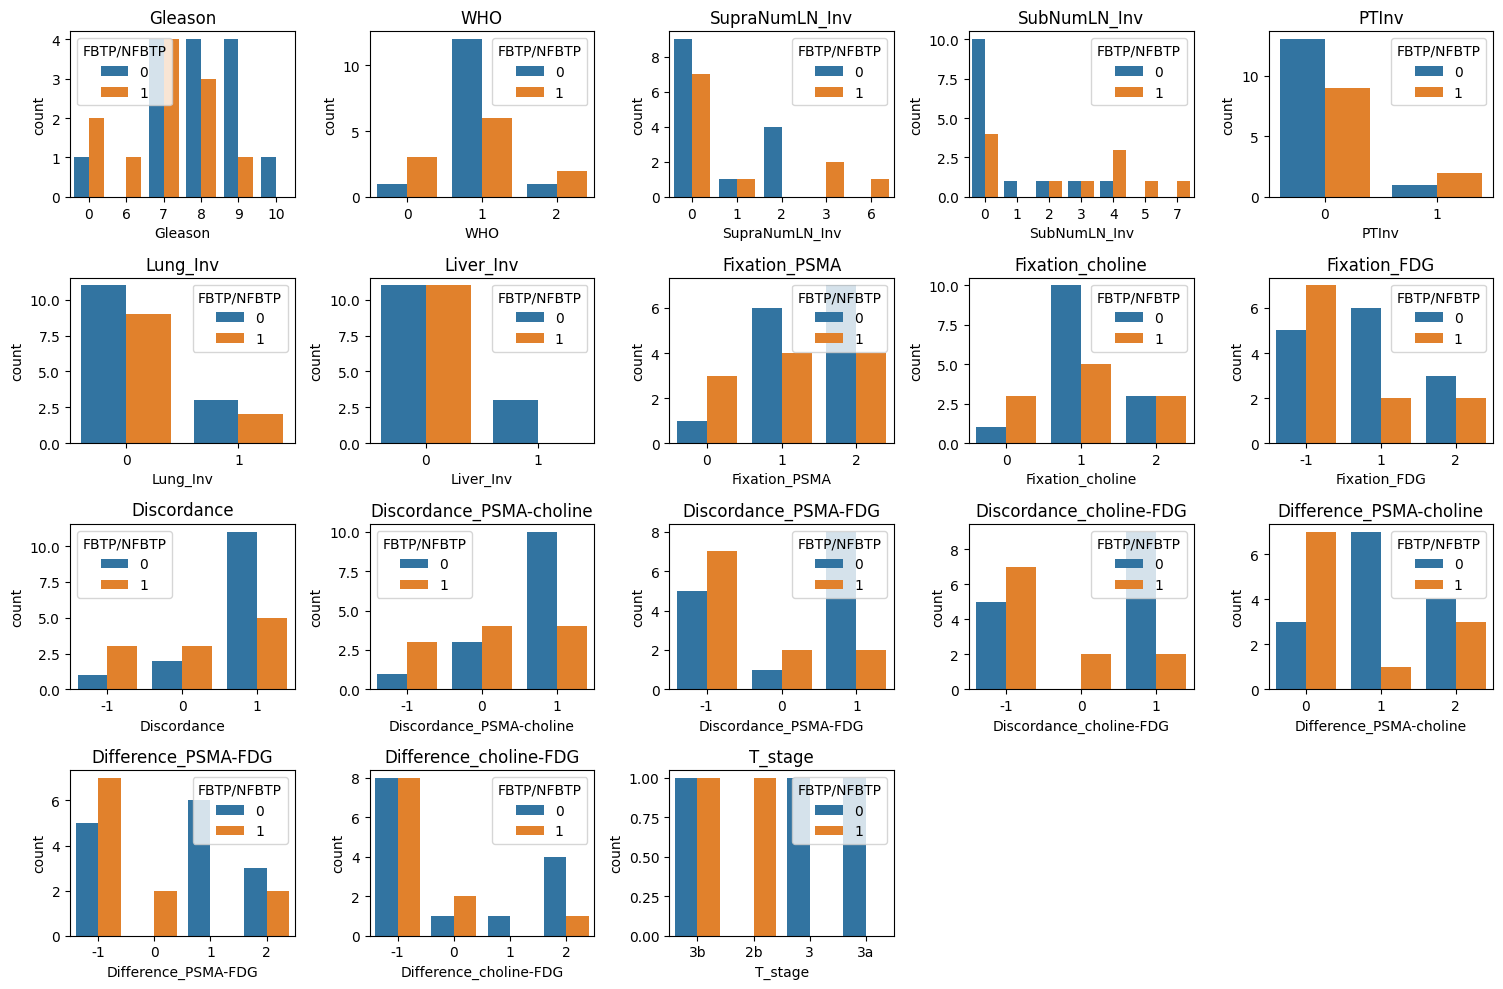

In [665]:
# Distibution of Categorical variables
df = pd.concat([Data_cat, Data_lab], axis=1)

n_cols = 5
n_rows = int(np.ceil(len(Data_cat.columns) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for idx, col in enumerate(Data_cat.columns):
    ax = axs[idx // n_cols, idx % n_cols]
    sns.countplot(x=col, hue=Data_lab.name, data=df, ax=ax)
    ax.set_title(col)

if len(Data_cat.columns) % n_cols != 0:
    for idx in range(len(Data_cat.columns), n_cols * n_rows):
        fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

### 4. Data Normalization and Encoding:

In [666]:
# Normalization of continuous variables
# Remove the influence of dimension and mean of features
# Z-score

scaler = MinMaxScaler()
Data_con_scaled = scaler.fit_transform(Data_con)
Data_con = pd.DataFrame(Data_con_scaled, columns=Data_con.columns, index=Data_con.index)

In [667]:
Data_cat

,Gleason,WHO,SupraNumLN_Inv,SubNumLN_Inv,PTInv,Lung_Inv,Liver_Inv,Fixation_PSMA,Fixation_choline,Fixation_FDG,Discordance,Discordance_PSMA-choline,Discordance_PSMA-FDG,Discordance_choline-FDG,Difference_PSMA-choline,Difference_PSMA-FDG,Difference_choline-FDG,T_stage
ID,,,,,,,,,,,,,,,,,,
1,9,2,2,0,0,0,1,2,1,1,1,1,1,1,2,1,0,3b
2,7,1,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,0,-1,-1,<NA>
3,8,0,0,0,0,0,0,1,1,-1,0,0,-1,-1,1,-1,-1,<NA>
4,8,1,0,0,0,0,0,1,1,-1,1,1,-1,-1,1,-1,-1,<NA>
5,7,0,0,0,0,0,0,1,1,-1,1,1,-1,-1,1,-1,-1,<NA>
6,6,1,6,7,0,0,0,1,1,-1,1,1,-1,-1,2,-1,-1,2b
7,0,1,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,0,-1,-1,<NA>
8,10,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,<NA>
10,7,1,1,0,0,1,0,2,2,1,1,1,1,1,1,1,2,3


In [668]:
# Encoding of Categorical variables

# Define ordinal and nominal characteristics'
ordinal_columns = ['Gleason', 'SupraNumLN_Inv', 'SubNumLN_Inv', 'T_stage', 'WHO', 'PTInv', 'Lung_Inv', 'Liver_Inv']
nominal_columns = ['Fixation_PSMA', 'Fixation_choline', 'Fixation_FDG',
                   'Discordance', 'Discordance_PSMA-choline', 'Discordance_PSMA-FDG', 'Discordance_choline-FDG',
                   'Difference_PSMA-choline', 'Difference_PSMA-FDG', 'Difference_choline-FDG']

Data_cat['T_stage'] = Data_cat['T_stage'].fillna('unknown')

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ordinal_columns),
        ('nom', nominal_transformer, nominal_columns)
    ])


X_processed = preprocessor.fit_transform(Data_cat)

onehot_features = preprocessor.named_transformers_['nom']['onehot'].get_feature_names_out()
all_features = ordinal_columns + list(onehot_features)

Data_cat = pd.DataFrame(X_processed, columns=all_features, index=Data_cat.index)

In [669]:
Data_var = pd.merge(Data_con, Data_cat, left_index=True, right_index=True)
Data = pd.concat([Data_var, Data_lab], axis=1)
Data.to_csv('../data/processed/Data.csv')